In [3]:
import pandas as pd

In [16]:
df = pd.read_csv("Symptom2Disease.csv")
df.head()

,Unnamed: 0,label,text
0,0,Psoriasis,I have been experiencing a skin rash on my arm...
1,1,Psoriasis,"My skin has been peeling, especially on my kne..."
2,2,Psoriasis,I have been experiencing joint pain in my fing...
3,3,Psoriasis,"There is a silver like dusting on my skin, esp..."
4,4,Psoriasis,"My nails have small dents or pits in them, and..."


In [17]:
df['label'].value_counts()

label
Psoriasis                          50
Varicose Veins                     50
peptic ulcer disease               50
drug reaction                      50
gastroesophageal reflux disease    50
allergy                            50
urinary tract infection            50
Malaria                            50
Jaundice                           50
Cervical spondylosis               50
Migraine                           50
Hypertension                       50
Bronchial Asthma                   50
Acne                               50
Arthritis                          50
Dimorphic Hemorrhoids              50
Pneumonia                          50
Common Cold                        50
Fungal infection                   50
Dengue                             50
Impetigo                           50
Chicken pox                        50
Typhoid                            50
diabetes                           50
Name: count, dtype: int64

# Natural Language Processing

## Pre-processing
tokenization, text cleaning (removing capitalization, punctuation, stopwords), and lemmatizing (getting the root words)


In [18]:
def nlp_preprocessing(corpus):
    from nltk.tokenize import RegexpTokenizer
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer

    sw = stopwords.words('english') + ["i've", "i'm"]
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)" 
    tokenizer = RegexpTokenizer(pattern)

    tokenized_corp = tokenizer.tokenize(corpus)
    lower_corp = [token.lower() for token in tokenized_corp]
    sw_corp = [token for token in lower_corp if token not in sw]

    lemmatizer = WordNetLemmatizer()

    lemmed_corp = [lemmatizer.lemmatize(token) for token in sw_corp]

    return lemmed_corp
    

In [19]:
df['processed'] = df['text'].apply(nlp_preprocessing)
df.head()

,Unnamed: 0,label,text,processed
0,0,Psoriasis,I have been experiencing a skin rash on my arm...,"[experiencing, skin, rash, arm, leg, torso, pa..."
1,1,Psoriasis,"My skin has been peeling, especially on my kne...","[skin, peeling, especially, knee, elbow, scalp..."
2,2,Psoriasis,I have been experiencing joint pain in my fing...,"[experiencing, joint, pain, finger, wrist, kne..."
3,3,Psoriasis,"There is a silver like dusting on my skin, esp...","[silver, like, dusting, skin, especially, lowe..."
4,4,Psoriasis,"My nails have small dents or pits in them, and...","[nail, small, dent, pit, often, feel, inflamma..."


### Explore each disease

In [51]:
def explore_symptoms(df, disease):
    df_disease = df[df['label'] == disease]

    disease_symp = []
    for index, row in df_disease.iterrows():
        disease_symp += row['processed']
    
    from nltk.probability import FreqDist
    import matplotlib.pyplot as plt

    fdist = FreqDist(disease_symp)
    plt.figure(figsize=(10, 10))
    fdist.plot(30)

    from wordcloud import WordCloud, ImageColorGenerator

    wordcloud = WordCloud().generate(' '.join(disease_symp))

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

#### Example 1: Psoriasis

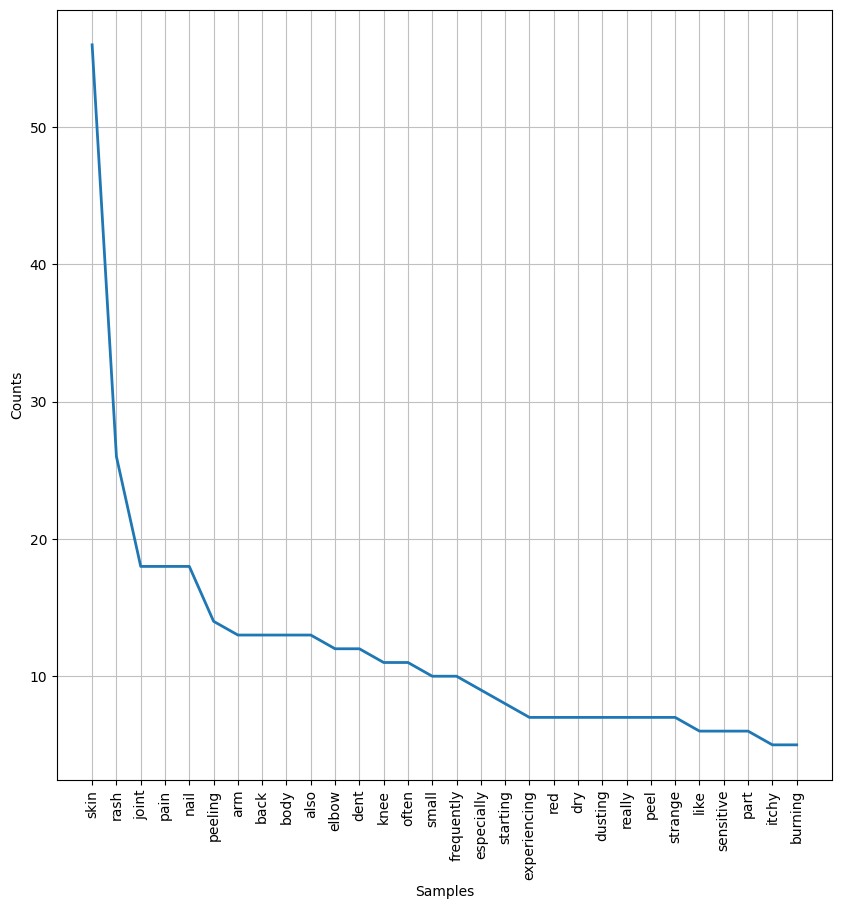

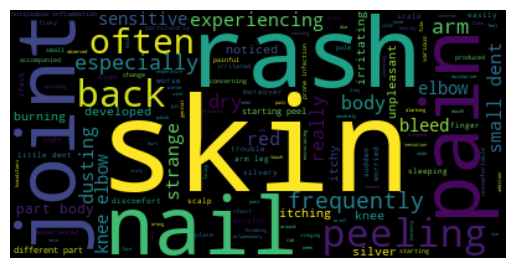

In [52]:
explore_symptoms(df, 'Psoriasis')

#### Example 2: Arthritis

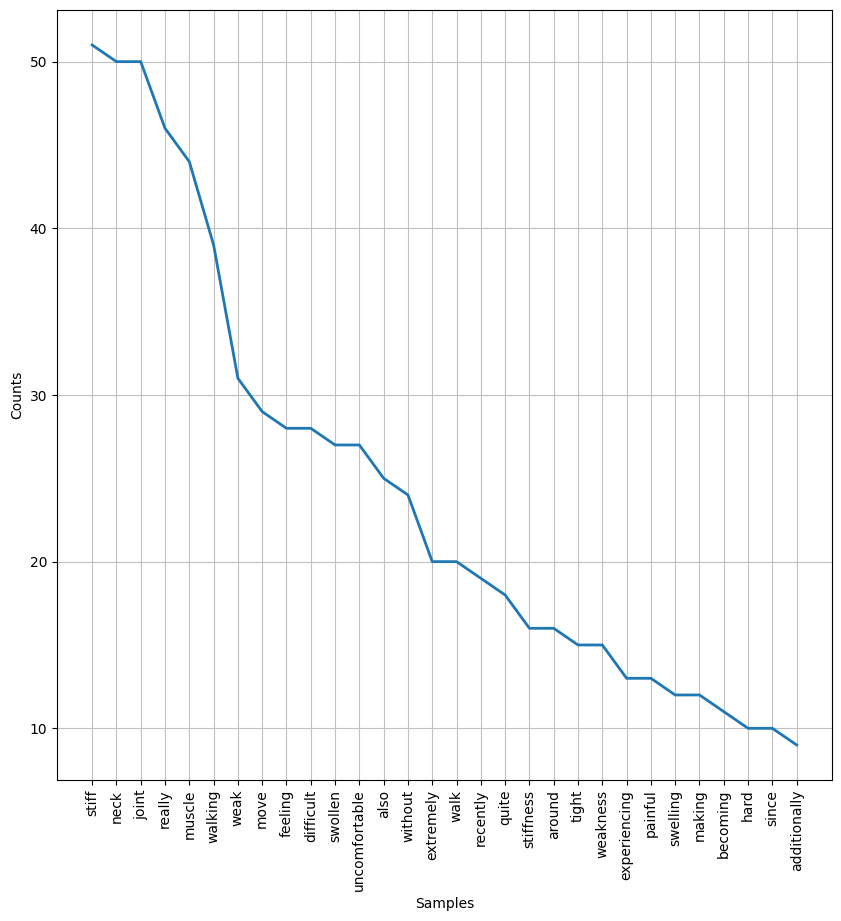

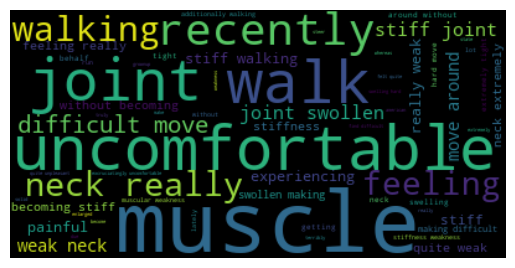

In [53]:
explore_symptoms(df, 'Arthritis')

## Feature Engineering
to pass text data to machine learning algorithm and perform classification

### train-test-split

Since there are only 50 samples from each disease, the split is completed only once, with 30% being the test set.

In [37]:
df['processed_str'] = df['processed'].apply(' '.join)

In [39]:
from sklearn.model_selection import train_test_split

text_data = df['processed_str']
label = df['label']

X_train, X_test, y_train, y_test = train_test_split(text_data, label, test_size=0.3, random_state=42)

### Vectorization

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

sw = stopwords.words('english') + ["i've", "i'm"]

tf_vec = TfidfVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)", stop_words=sw)
X_train_vec = tf_vec.fit_transform(X_train)
X_test_vec = tf_vec.transform(X_test)

In [44]:
df_X_train_vec = pd.DataFrame(X_train_vec.toarray(), columns=tf_vec.get_feature_names_out())
df_X_test_vec = pd.DataFrame(X_test_vec.toarray(), columns=tf_vec.get_feature_names_out())

,abdomen,abdominal,ability,able,abound,absolutely,aburning,accomapanied,accompanied,ache,...,worrying,worse,worst,wound,wrong,yeast,yellow,yellowish,yesterday,yet
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.318766,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.255294,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.312825,0.0,0.0,0.0,0.0,0.0,0.0,0.325342,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.235132,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


## Classification Modeling